In [4]:
import torch_geometric
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.data import DataLoader
from ogb.graphproppred.mol_encoder import AtomEncoder
from torch_geometric import utils
from torch_geometric.utils import to_dense_adj
import torch
import networkx as nx
import matplotlib.cm as cm


In [2]:
dataset = PygGraphPropPredDataset(name='ogbg-molhiv')

In [3]:
split_idx = dataset.get_idx_split()
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False)

/home/ziv/miniconda3/envs/stitt/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:

d = dataset[2]
encoder = AtomEncoder(emb_dim=4096)
emb = encoder(d.x).detach()

adj_matrix = to_dense_adj(d.edge_index)[0]
eigenvalues, eigenvectors = torch.eig(adj_matrix, eigenvectors=True)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = torch.argsort(eigenvalues[:, 0], descending=True)
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

dx = utils.to_networkx(d)


/tmp/ipykernel_1715722/3861915648.py:6: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2894.)
  eigenvalues, eigenvectors = torch.eig(adj_matrix, eigenvectors=True)


In [8]:
i, g = next(enumerate(next((iter(train_loader)))[:19]))

In [9]:
def calc_degree(adj_matrix: torch.Tensor):
    return torch.sum(adj_matrix, dim=1)

RuntimeError: Index tensor must have the same number of dimensions as self tensor

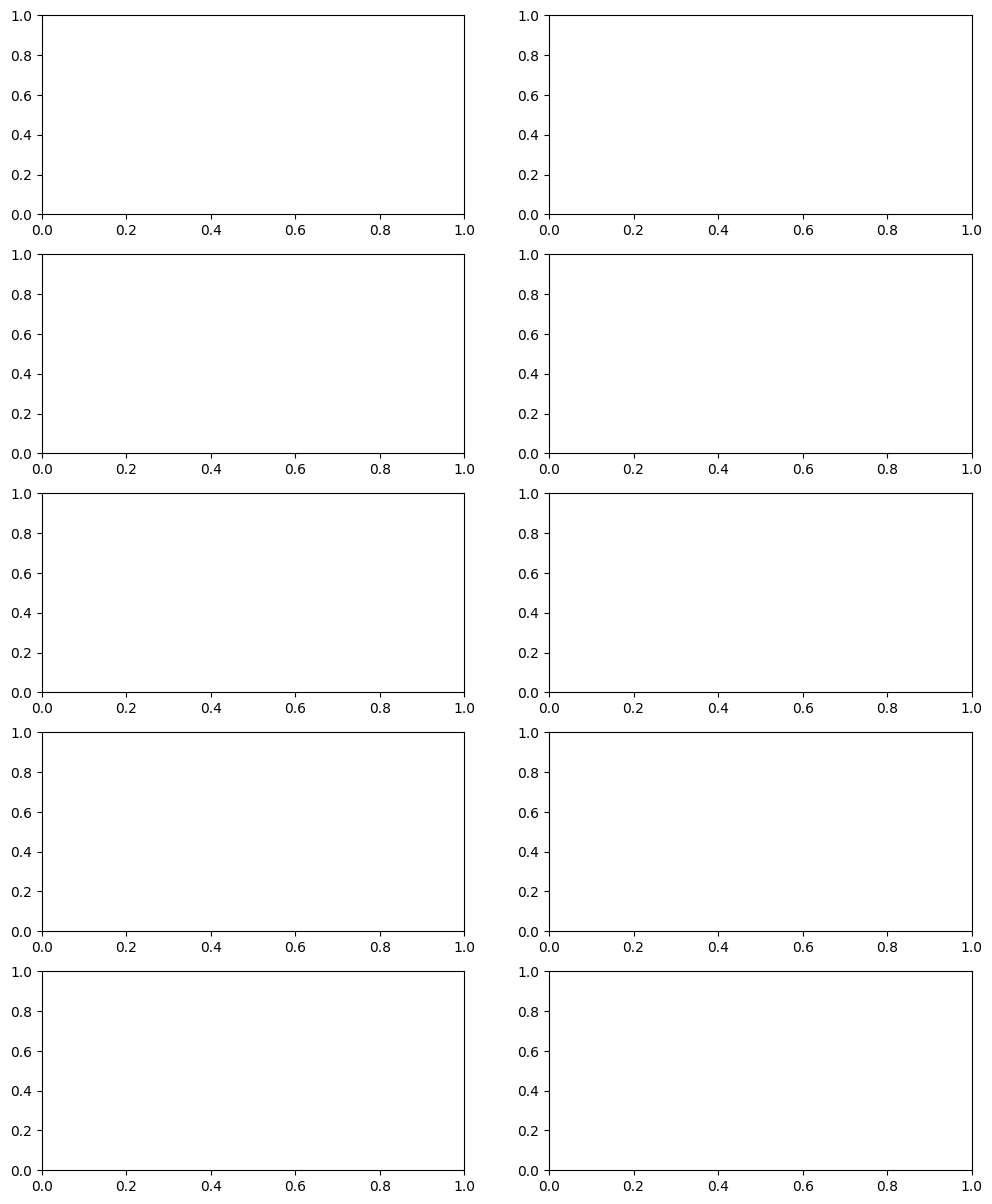

In [71]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(12, 15))

for i, graph in enumerate(next((iter(train_loader)))[:10]):
  A = to_dense_adj(graph.edge_index)[0]
  D = calc_degree(A)
  N = torch.eye_like(A) - torch.pow(D, -1) * A
  eigenvalues, eigenvectors = torch.eig(N, eigenvectors=True)
  sorted_indices = torch.argsort(eigenvalues[:, 0], descending=True)
  sorted_eigenvalues = eigenvalues[sorted_indices]
  sorted_eigenvectors = eigenvectors[:, sorted_indices]
  
  norm_eig = torch.functional.F.softmax(sorted_eigenvalues[:2,0], dim=0)
  eigvects = sorted_eigenvectors[:, :2]
  signal = torch.matmul(eigvects, norm_eig)
  # Create a list of colors based on sorted_eigenvectors
  colors = [signal[j] for j in range(len(sorted_eigenvectors))]
  dx = utils.to_networkx(graph)

  # Draw the graph with node colors
  nx.draw(dx, node_color=colors, with_labels=True, ax=axs[i//2][i%2],
          cmap=cm.jet_r, vmin=min(colors), vmax=max(colors))

  # Add colorbar
  sm = cm.ScalarMappable(cmap=cm.jet_r)
  sm.set_array(colors)
  fig.colorbar(sm, ax=axs[i//2][i%2])


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [57]:
norm_eig = torch.functional.F.softmax(sorted_eigenvalues[:5,0], dim=0)
eigvects = sorted_eigenvectors[:, :5]
signal = torch.matmul(eigvects, norm_eig)

tensor([0.3135, 0.2590, 0.1745, 0.1407, 0.1123])